In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import psycopg2
import scipy.stats

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import src.stat_helpers as stat_helpers
import src.wrangle_helpers as wrangle_helpers

In [4]:
df_2019, groomed_df = wrangle_helpers.load_and_wrangle_data('../../data/housing2019.csv')

In [5]:
groomed_df['TownshipMeanSalePrice'].value_counts()

1141350    6251
913485     6221
814463     5432
553113     4373
490340     3709
447479     3170
501425      462
326750        3
Name: TownshipMeanSalePrice, dtype: int64

In [6]:
township_mean_sale_prices = {}
for town in df_2019['Township'].value_counts().index:
#     print(f"{town}: ", df_2019[df_2019['Township'] == town]['SalePrice'].mean())
    township_mean_sale_prices[town] = df_2019[df_2019['Township'] == town]['SalePrice'].mean()
township_mean_sale_prices
# sorted_dict = sorted(township_mean_sale_prices.items(), key=lambda x: x[1])
# sorted_dict

{25: 1141350.1974084147,
 24: 913485.7444140813,
 26: 814463.6520618557,
 23: 553113.3862337068,
 22: 490340.96521973575,
 21: 447479.7047318612,
 20: 501425.0,
 19: 326750.0}

''

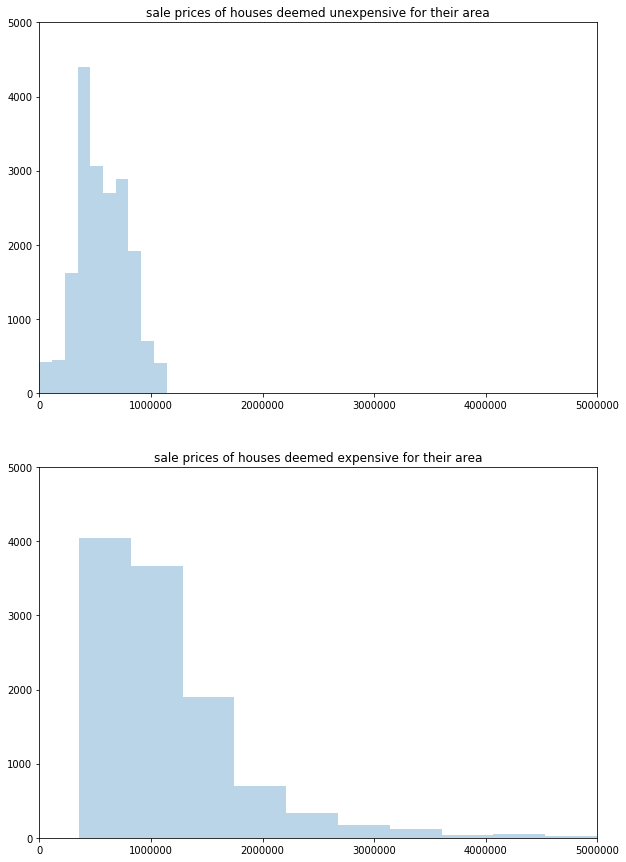

In [7]:
groomed_df['TownshipMeanSalePrice'] = groomed_df['Township'].map(township_mean_sale_prices)
groomed_df['TownshipMeanSalePrice'] = groomed_df['TownshipMeanSalePrice'].astype(int)
groomed_df['ExpensiveForArea?'] = (groomed_df['SalePrice'] >= groomed_df['TownshipMeanSalePrice']).astype(int)
groomed_df['ExpensiveForArea?']
fig, axs = plt.subplots(2, figsize=(10,15))
axs[0].set_ylim(0,5000)
axs[0].set_xlim(0,5000000)
axs[0].set_title('sale prices of houses deemed unexpensive for their area')

axs[0].hist(groomed_df[groomed_df['ExpensiveForArea?']==0]['SalePrice'],  alpha=0.3)

axs[1].set_ylim(0,5000)
axs[1].set_xlim(0,5000000)
axs[1].set_title('sale prices of houses deemed expensive for their area')
axs[1].hist(groomed_df[groomed_df['ExpensiveForArea?']==1]['SalePrice'],  alpha=0.3)

;


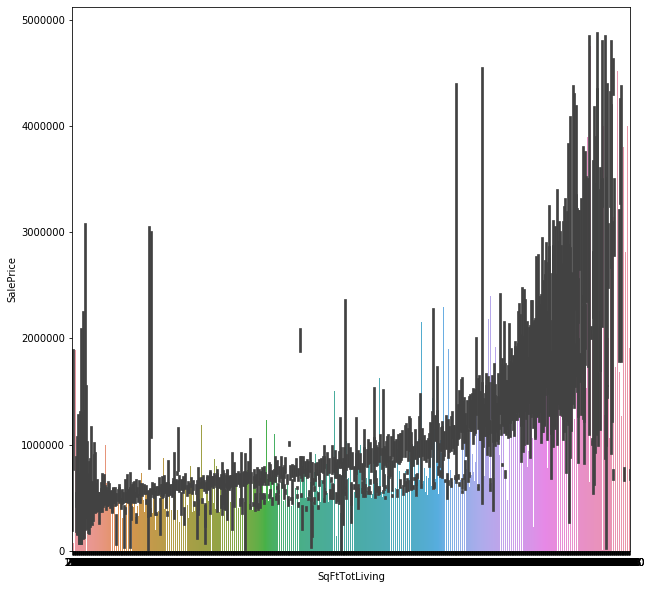

In [8]:
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.barplot(df_2019['SqFtTotLiving'], df_2019['SalePrice'])


### Base Model

In [9]:
fsm = ols(formula='SalePrice ~ SqFtTotLiving', data=groomed_df).fit().summary()
fsm

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                 1.547e+04
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        09:25:33   Log-Likelihood:            -4.2558e+05
No. Observations:               29621   AIC:                         8.512e+05
Df Residuals:                   29619   BIC:                         8.512e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       1.24e+05   5818.374     21.317      0.000    1.13e+05    1.35e+05
SqFtTotLiving   303.8229      2.443    124.375      0.000     299.035     308.611
==============================================================================
Omnibus:                    15543.448   Durbin-Watson:                   1.610
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           229982.402
Skew:                           2.184   Prob(JB):                         0.00
Kurtosis:                      15.933   Cond. No.                     5.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Current Most Predictive Model and its Features' Colinearity

In [10]:
columns = ['BldgGrade', 'SqFtOpenPorch', 'SqFtDeck', 'TidelandShoreland', 'TrafficNoise', 'MtRainier', 'Olympics', 'Cascades', 'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek', 'OtherView', 'TownshipMeanSalePrice']
stat_helpers.get_VIF(groomed_df, columns)


,Feature,VIF
0,BldgGrade,12.108550
1,SqFtOpenPorch,1.385426
2,SqFtDeck,1.535019
3,TidelandShoreland,1.452820
4,TrafficNoise,1.183042
5,MtRainier,1.130764
6,Olympics,2.086767
7,Cascades,1.484788
8,Territorial,2.976204
9,SeattleSkyline,1.147182


In [11]:
columns = ['BldgGrade', 'SqFtOpenPorch', 'SqFtDeck', 'TidelandShoreland', 'TrafficNoise', 'MtRainier', 'Olympics', 'Cascades', 'Territorial', 'SeattleSkyline', 'PugetSound', 'LakeWashington', 'LakeSammamish', 'SmallLakeRiverCreek', 'OtherView']
stat_helpers.generate_ols_summary(groomed_df, columns).summary()
# groomed_df['ExpensiveForArea?']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     1503.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        09:25:33   Log-Likelihood:            -4.2342e+05
No. Observations:               29621   AIC:                         8.469e+05
Df Residuals:                   29605   BIC:                         8.470e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept           -1.035e+06   1.59e+04    -64.932      0.000   -1.07e+06      -1e+06
BldgGrade            2.257e+05   2125.704    106.199      0.000    2.22e+05     2.3e+05
SqFtOpenPorch         417.1577     16.474     25.322      0.000     384.868     449.448
SqFtDeck               92.9980     11.390      8.165      0.000      70.673     115.323
TidelandShoreland    3.249e+05   3.28e+04      9.901      0.000    2.61e+05    3.89e+05
TrafficNoise          5.81e+04   6481.092      8.965      0.000    4.54e+04    7.08e+04
MtRainier           -2332.8302   9627.997     -0.242      0.809   -2.12e+04    1.65e+04
Olympics              8.72e+04   8408.561     10.371      0.000    7.07e+04    1.04e+05
Cascades            -2825.0614   6744.152     -0.419      0.675    -1.6e+04    1.04e+04
Territorial         -1885.8231   4907.482     -0.384      0.701   -1.15e+04    7733.057
SeattleSkyline       1.374e+05      1e+04     13.692      0.000    1.18e+05    1.57e+05
PugetSound           4852.1620   8824.030      0.550      0.582   -1.24e+04    2.21e+04
LakeWashington        2.11e+05   7848.907     26.879      0.000    1.96e+05    2.26e+05
LakeSammamish        2.574e+05   1.24e+04     20.760      0.000    2.33e+05    2.82e+05
SmallLakeRiverCreek  6.728e+04   8124.626      8.281      0.000    5.14e+04    8.32e+04
OtherView             6.16e+04   1.34e+04      4.587      0.000    3.53e+04    8.79e+04
==============================================================================
Omnibus:                    16284.513   Durbin-Watson:                   1.698
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           281268.302
Skew:                           2.273   Prob(JB):                         0.00
Kurtosis:                      17.396   Cond. No.                     3.71e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Exploratory Models

In [21]:
fsm = ols(formula='SalePrice ~ BldgGrade', data=groomed_df).fit().summary()
fsm

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.356
Model:                            OLS   Adj. R-squared:                  0.356
Method:                 Least Squares   F-statistic:                 1.636e+04
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        09:28:34   Log-Likelihood:            -4.2529e+05
No. Observations:               29621   AIC:                         8.506e+05
Df Residuals:                   29619   BIC:                         8.506e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -1.24e+06    1.6e+04    -77.586      0.000   -1.27e+06   -1.21e+06
BldgGrade   2.628e+05   2054.490    127.924      0.000    2.59e+05    2.67e+05
==============================================================================
Omnibus:                    17668.502   Durbin-Watson:                   1.696
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           260512.534
Skew:                           2.609   Prob(JB):                         0.00
Kurtosis:                      16.559   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
columns = ['SqFtTotLiving', 'TidelandShoreland', 'SqFtOpenPorch', 'SqFtDeck', 'Area', 'Bath3qtrCount', 'LakeSammamish', 'LakeWashington', 'SeattleSkyline', 'YrBuilt', 'YrRenovated']
stat_helpers.generate_ols_summary(groomed_df, columns).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.422
Method:                 Least Squares   F-statistic:                     1969.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        09:25:33   Log-Likelihood:            -4.2368e+05
No. Observations:               29621   AIC:                         8.474e+05
Df Residuals:                   29609   BIC:                         8.475e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          2.653e+06   1.59e+05     16.736      0.000    2.34e+06    2.96e+06
SqFtTotLiving       281.9615      2.881     97.867      0.000     276.314     287.609
TidelandShoreland   4.36e+05   2.97e+04     14.659      0.000    3.78e+05    4.94e+05
SqFtOpenPorch       221.3497     17.594     12.581      0.000     186.864     255.835
SqFtDeck            107.5149     11.415      9.418      0.000      85.140     129.889
Area              -1424.9206     87.271    -16.328      0.000   -1595.975   -1253.866
Bath3qtrCount      1.624e+04   3582.084      4.535      0.000    9222.178    2.33e+04
LakeSammamish      2.663e+05    1.2e+04     22.188      0.000    2.43e+05     2.9e+05
LakeWashington     1.829e+05   6777.100     26.990      0.000     1.7e+05    1.96e+05
SeattleSkyline     1.805e+05   9716.097     18.582      0.000    1.61e+05       2e+05
YrBuilt           -1253.4278     81.412    -15.396      0.000   -1412.998   -1093.857
YrRenovated          49.5318      5.773      8.581      0.000      38.217      60.846
==============================================================================
Omnibus:                    13616.888   Durbin-Watson:                   1.613
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           226715.530
Skew:                           1.791   Prob(JB):                         0.00
Kurtosis:                      16.072   Cond. No.                     2.10e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Single Feature Relationships w/ SalePrice

##### SqFtTotLiving

In [13]:
fsm = ols(formula='SalePrice ~ SqFtTotLiving', data=groomed_df).fit()
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                 1.547e+04
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        09:25:33   Log-Likelihood:            -4.2558e+05
No. Observations:               29621   AIC:                         8.512e+05
Df Residuals:                   29619   BIC:                         8.512e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       1.24e+05   5818.374     21.317      0.000    1.13e+05    1.35e+05
SqFtTotLiving   303.8229      2.443    124.375      0.000     299.035     308.611
==============================================================================
Omnibus:                    15543.448   Durbin-Watson:                   1.610
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           229982.402
Skew:                           2.184   Prob(JB):                         0.00
Kurtosis:                      15.933   Cond. No.                     5.68e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

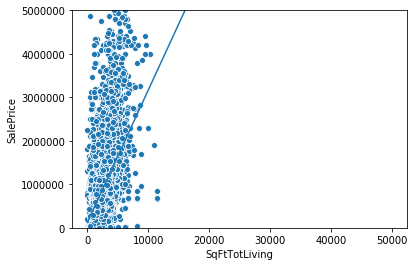

In [14]:
x = np.linspace(0, 50000)
m = fsm.params.SqFtTotLiving
b = fsm.params.Intercept
fig, ax = plt.subplots()
ax.set_ylim(0,5000000)
ax = sns.scatterplot(groomed_df['SqFtTotLiving'], groomed_df['SalePrice'])
ax = sns.lineplot(x, (m*x + b))

##### SqFtOpenPorch

In [15]:
fsm = ols(formula='SalePrice ~ SqFtOpenPorch', data=groomed_df).fit()
fsm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     2540.
Date:                Thu, 05 Mar 2020   Prob (F-statistic):               0.00
Time:                        09:25:34   Log-Likelihood:            -4.3059e+05
No. Observations:               29621   AIC:                         8.612e+05
Df Residuals:                   29619   BIC:                         8.612e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      7.023e+05   3284.960    213.790      0.000    6.96e+05    7.09e+05
SqFtOpenPorch  1000.1924     19.844     50.402      0.000     961.297    1039.088
==============================================================================
Omnibus:                    16563.878   Durbin-Watson:                   1.695
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           398015.510
Skew:                           2.213   Prob(JB):                         0.00
Kurtosis:                      20.404   Cond. No.                         188.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

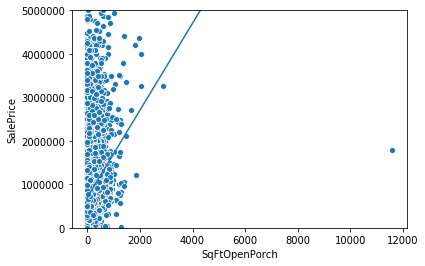

In [16]:
x = np.linspace(0, 10000)
m = fsm.params.SqFtOpenPorch
b = fsm.params.Intercept
fig, ax = plt.subplots()
ax.set_ylim(0,5000000)
ax = sns.scatterplot(groomed_df['SqFtOpenPorch'], groomed_df['SalePrice'])
ax = sns.lineplot(x, (m*x + b))

##### Tideland Shoreland

In [17]:
stat_helpers.get_VIF(groomed_df, ['SalePrice', 'TidelandShoreland'])

,Feature,VIF
0,SalePrice,1.024231
1,TidelandShoreland,1.024231


In [18]:
stat_helpers.bootstrapped_ttest_bin(groomed_df, 'TidelandShoreland')

('p-value: ', 0.00018728035993916846, 'statistic: ', 5.064771526743781)